In [ ]:
#| eval: false

import warnings
warnings.filterwarnings('ignore')

from fastai.vision.all import *
from fasterbench.benchmark import evaluate_cpu_speed, get_model_size, get_num_parameters

In [ ]:
#| eval: false
import torch.nn as nn
import torch
class dfus_block(nn.Module):
    def __init__(self, dim):
        super(dfus_block, self).__init__()
        self.conv1 = nn.Conv2d(dim, 128, 1, 1, 0, bias=False)

        self.conv_up1 = nn.Conv2d(128, 32, 3, 1, 1, bias=False)
        self.conv_up2 = nn.Conv2d(32, 16, 1, 1, 0, bias=False)

        self.conv_down1 = nn.Conv2d(128, 32, 3, 1, 1, bias=False)
        self.conv_down2 = nn.Conv2d(32, 16, 1, 1, 0, bias=False)

        self.conv_fution = nn.Conv2d(96, 32, 1, 1, 0, bias=False)

        #### activation function
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        """
        x: [b,c,h,w]
        return out:[b,c,h,w]
        """
        feat = self.relu(self.conv1(x))
        feat_up1 = self.relu(self.conv_up1(feat))
        feat_up2 = self.relu(self.conv_up2(feat_up1))
        feat_down1 = self.relu(self.conv_down1(feat))
        feat_down2 = self.relu(self.conv_down2(feat_down1))
        feat_fution = torch.cat([feat_up1,feat_up2,feat_down1,feat_down2],dim=1)
        feat_fution = self.relu(self.conv_fution(feat_fution))
        out = torch.cat([x, feat_fution], dim=1)
        return out

class ddfn(nn.Module):
    def __init__(self, dim, num_blocks=78):
        super(ddfn, self).__init__()

        self.conv_up1 = nn.Conv2d(dim, 32, 3, 1, 1, bias=False)
        self.conv_up2 = nn.Conv2d(32, 32, 1, 1, 0, bias=False)

        self.conv_down1 = nn.Conv2d(dim, 32, 3, 1, 1, bias=False)
        self.conv_down2 = nn.Conv2d(32, 32, 1, 1, 0, bias=False)

        dfus_blocks = [dfus_block(dim=128+32*i) for i in range(num_blocks)]
        self.dfus_blocks = nn.Sequential(*dfus_blocks)

        #### activation function
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        """
        x: [b,c,h,w]
        return out:[b,c,h,w]
        """
        feat_up1 = self.relu(self.conv_up1(x))
        feat_up2 = self.relu(self.conv_up2(feat_up1))
        feat_down1 = self.relu(self.conv_down1(x))
        feat_down2 = self.relu(self.conv_down2(feat_down1))
        feat_fution = torch.cat([feat_up1,feat_up2,feat_down1,feat_down2],dim=1)
        out = self.dfus_blocks(feat_fution)
        return out

class HSCNN_Plus(nn.Module):
    def __init__(self, in_channels=3, out_channels=31, num_blocks=30):
        super(HSCNN_Plus, self).__init__()

        self.ddfn = ddfn(dim=in_channels, num_blocks=num_blocks)
        self.conv_out = nn.Conv2d(128+32*num_blocks, out_channels, 1, 1, 0, bias=False)

    def forward(self, x):
        """
        x: [b,c,h,w]
        return out:[b,c,h,w]
        """
        fea = self.ddfn(x)
        out =  self.conv_out(fea)
        return out

In [ ]:
#| eval: false

# def get_dls(size, bs):
#     path = URLs.IMAGENETTE_160
#     source = untar_data(path)
#     blocks=(ImageBlock, CategoryBlock)
#     tfms = [RandomResizedCrop(size, min_scale=0.35), FlipItem(0.5)]
#     batch_tfms = [Normalize.from_stats(*imagenet_stats)]

#     csv_file = 'noisy_imagenette.csv'
#     inp = pd.read_csv(source/csv_file)
#     dblock = DataBlock(blocks=blocks,
#                splitter=ColSplitter(),
#                get_x=ColReader('path', pref=source),
#                get_y=ColReader(f'noisy_labels_0'),
#                item_tfms=tfms,
#                batch_tfms=batch_tfms)

#     return dblock.dataloaders(inp, path=source, bs=bs)

In [ ]:
#| eval: false
# size, bs = 128, 32
# dls = get_dls(size, bs)

In [ ]:
#| eval: false
model_path = Path('/root/Ninjalabo/HSI/MST-plus-plus/MST-plus-plus/test_challenge_code/model_zoo/hscnn_plus.pth')

# path = '/root/Ninjalabo/HSI/MST-plus-plus/MST-plus-plus/dataset/Train_RGB/'

In [ ]:
#| eval: false
from fastai.vision.all import *
from pathlib import Path
import torch

# Set your dataset path
path = Path('/root/Ninjalabo/HSI/MST-plus-plus/MST-plus-plus/dataset/')
val_path = path / 'Train_RGB'  # Adjust based on your folder structure


In [ ]:
#| eval: false
# from fastai.vision.all import *

# Define the path to your dataset
path = Path('/root/Ninjalabo/HSI/MST-plus-plus/MST-plus-plus/dataset/')  # Set this to your validation data folder

# DataBlock for image-to-image tasks
data_block = DataBlock(
    blocks=(ImageBlock, ImageBlock),  # Both input and output are images
    get_items=get_image_files,  # Gets the image files
    get_x=lambda f: PILImage.create(f),  # Use image as input
    get_y=lambda f: PILImage.create(f),  # Use the same image as output
    splitter=RandomSplitter(valid_pct=0.2),  # Split for training/validation (adjust as needed)
    item_tfms=Resize(64),  # Resize transformation, adjust as per your requirement
)

# Create DataLoaders
dls = data_block.dataloaders(path, bs=1)  # Adjust batch size based on memory limits


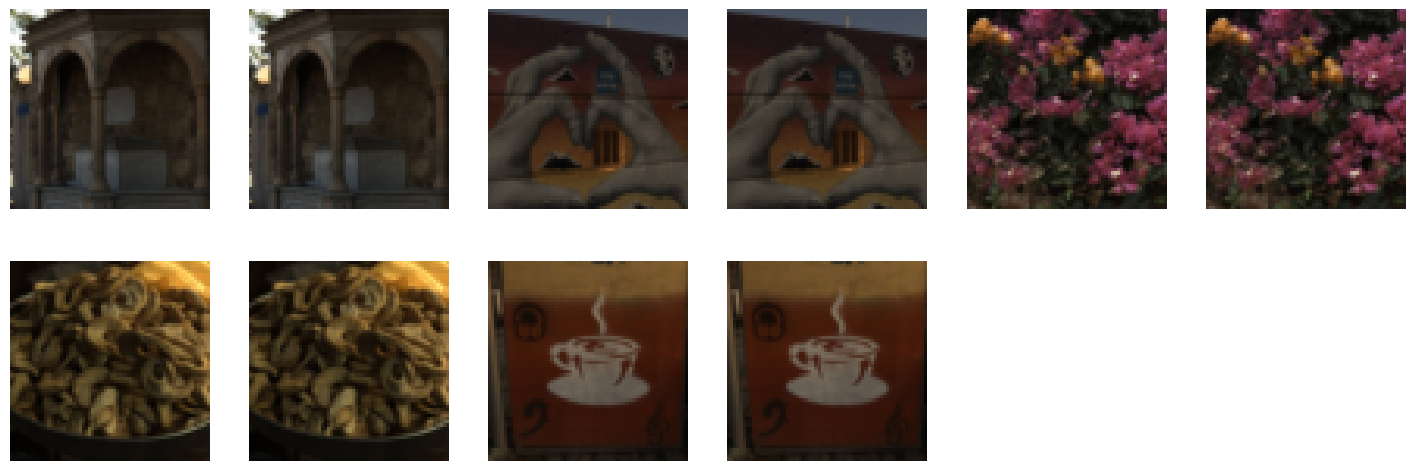

In [ ]:
#| eval: false
dls = data_block.dataloaders(val_path, bs=5)  # Use the appropriate batch size
dls.show_batch()

In [ ]:
#| eval: false
# Grab a batch from the training DataLoader
x, y = dls.one_batch()

# Check the shape of inputs and outputs
print("Input (x) shape:", x.shape)
print("Target (y) shape:", y.shape)


Input (x) shape: torch.Size([5, 3, 64, 64])
Target (y) shape: torch.Size([5, 3, 64, 64])


In [ ]:
#| eval: false
# model = HSCNN_Plus()
# checkpoint = torch.load(model_path)
# if 'state_dict' in checkpoint:
#     model.load_state_dict(checkpoint['state_dict'])
# else:
#     model.load_state_dict(checkpoint)
# model.eval()


In [ ]:
#| eval: false
model = HSCNN_Plus()  # Initialize your custom model

# Load model checkpoint
checkpoint = torch.load(model_path, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
if 'state_dict' in checkpoint:
    model.load_state_dict(checkpoint['state_dict'])
else:
    model.load_state_dict(checkpoint)

model.eval()  # Set to evaluation mode (good practice for inference)


HSCNN_Plus(
  (ddfn): ddfn(
    (conv_up1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (conv_up2): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (conv_down1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (conv_down2): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (dfus_blocks): Sequential(
      (0): dfus_block(
        (conv1): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (conv_up1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (conv_up2): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (conv_down1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (conv_down2): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (conv_fution): Conv2d(96, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (relu): ReLU(inplace=True)
     

In [ ]:
#| eval: false
from torch.nn import MSELoss

# Create the Learner with MSE Loss
learn = Learner(dls, model, loss_func=MSELoss())


In [ ]:
#| eval: false
from torch.nn import MSELoss
# Train or fine-tune the model (optional)
model = HSCNN_Plus(in_channels=3, out_channels=3, num_blocks=5)  # Reduce num_blocks significantly
learn = Learner(dls, model.to('cpu'), loss_func=MSELoss())

learn.fit_one_cycle(5, lr_max=1e-4)
# learn.fit_one_cycle(4, 1e-4)
# Run inference on validation set
# preds, targs = learn.get_preds(dl=dls.valid)  # Get predictions


epoch,train_loss,valid_loss,time
0,0.021460,0.003632,00:04
1,0.003802,0.002248,00:03
2,0.001616,0.001145,00:03
3,0.000952,0.000803,00:03
4,0.000814,0.000753,00:03


In [ ]:
#| eval: false
# from fastai.callback.all import GradientAccumulation

# # Set gradient accumulation steps to effectively multiply your batch size by this factor
# accumulation_steps = 8  # Adjust based on your needs and memory constraints

# # Create the Learner with gradient accumulation and mixed precision
# learn = Learner(dls, model, loss_func=MSELoss(), cbs=[GradientAccumulation(n_acc=accumulation_steps)]).to_fp16()
# learn.fit_one_cycle(5, lr_max=1e-4)

In [ ]:
#| eval: false
# files = get_image_files(path)

# def label_func(f): return f[0].isupper()

# dls = ImageDataLoaders.from_name_func(path, files, label_func, item_tfms=Resize(128),bs=32)



In [ ]:
#| eval: false
import torch
torch.cuda.empty_cache()


In [ ]:
#| eval: false
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"


In [ ]:
#| eval: false
from torch.nn import MSELoss  # Use Mean Squared Error as loss function for image-to-image tasks

# Define the Learner with MSE loss
learn = Learner(dls, model, loss_func=MSELoss())


In [ ]:
#| eval: false
# learn = Learner(dls, model, metrics=[accuracy])

In [ ]:
#| eval: false
num_parameters = get_num_parameters(learn.model)
disk_size = get_model_size(learn.model)
print(f"Model Size: {disk_size / 1e6:.2f} MB (disk), {num_parameters} parameters")

Model Size: 18.66 MB (disk), 4645504 parameters


In [ ]:
#| eval: false
model = learn.model.eval().to('cpu')
x,y = dls.one_batch()

In [ ]:
#| eval: false
print(f'Inference Speed: {evaluate_cpu_speed(learn.model, x[0][None])[0]:.2f}ms')

Inference Speed: 534.66ms


In [ ]:
#| eval: false
x, y = dls.one_batch()
print("Input Shape:", x.shape)
print("Target Shape:", y.shape)


Input Shape: torch.Size([5, 3, 128, 128])
Target Shape: torch.Size([5, 3, 128, 128])


---

<br>

## **Knowledge Distillation**

<br>

<blockquote>
<pre><b><i> KnowledgeDistillation(teacher.model, loss) </i></b></pre>
<p style="font-size: 15px"><i>
You only need to give to the callback function your teacher learner. Behind the scenes, FasterAI will take care of making your model train using knowledge distillation.
</i></p>
</blockquote>

<br>

In [ ]:
#| eval: false
from fasterai.distill.all import *

In [ ]:
#| eval: false
import torch

torch.cuda.empty_cache()


In [ ]:
#| eval: false
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [ ]:
#| eval: false
# sum(p.numel() for p in model.parameters() if p.requires_grad) / 1e6  # Total trainable parameters in millions


In [ ]:
#| eval: false
# import torch

# print(f"Allocated memory: {torch.cuda.memory_allocated() / 1024 ** 2:.2f} MB")
# print(f"Cached memory: {torch.cuda.memory_reserved() / 1024 ** 2:.2f} MB")


In [ ]:
#| eval: false
# !nvidia-smi


In [ ]:
#| eval: false
# !kill -9 58089      


In [ ]:
#| eval: false
from torch.nn import MSELoss
# Train or fine-tune the model (optional)
model = HSCNN_Plus(in_channels=3, out_channels=3, num_blocks=5)  # Reduce num_blocks significantly
teacher = Learner(dls, model.to('cpu'), loss_func=MSELoss())

teacher.fit_one_cycle(10, lr_max=1e-4)
# learn.fit_one_cycle(4, 1e-4)

epoch,train_loss,valid_loss,time
0,0.048989,0.035962,00:03
1,0.006988,0.003194,00:03
2,0.002478,0.001729,00:03
3,0.001107,0.000762,00:03
4,0.000556,0.000439,00:03
5,0.000377,0.000308,00:03
6,0.000280,0.000241,00:03
7,0.000247,0.000212,00:03
8,0.000226,0.000202,00:03
9,0.000222,0.000200,00:03


In [ ]:
#| eval: false
# from fastai.vision.all import *
# import torch

# # Define PSNR metric
# def psnr(pred, target, max_val=1.0):
#     mse = F.mse_loss(pred, target)
#     psnr_value = 20 * torch.log10(max_val) - 10 * torch.log10(mse)
#     return psnr_value

# # Wrap PSNR as a fastai metric
# class PSNR(Metric):
#     def __init__(self, max_val=1.0):  # Set max_val based on your data range (1.0 for normalized images)
#         self.max_val = max_val
    
#     def reset(self): self.psnr = 0
#     def accumulate(self, learn): self.psnr += psnr(learn.pred, learn.y)
#     @property
#     def value(self): return self.psnr


In [ ]:

#| eval: false


from fastai.vision.all import *
from fastai.callback.all import *
from fastai.vision.models.unet import DynamicUnet
from torchvision.models import resnet18

# Step 1: Define the student model with Tiny U-Net structure
# Use only the feature layers (up to the last convolution) of ResNet-18 as the encoder
encoder = nn.Sequential(*list(resnet18(pretrained=True).children())[:-2])  # Remove the last fully connected layers
student_model = DynamicUnet(encoder, n_out=3, img_size=(64, 64))  # Match output channels for your task

# Step 2: Define the Learner for the student model
# Set a suitable loss function for image-to-image tasks like MSELoss
student = Learner(
    dls, 
    student_model, 
    loss_func=MSELoss()#, 
    # metrics=[PSNR()]  # PSNR (Peak Signal-to-Noise Ratio) can be useful for image quality
)

# Step 3: Initialize the KnowledgeDistillationCallback
# Assuming `teacher` is the pre-trained HSCNN_Plus model
kd_cb = KnowledgeDistillationCallback(teacher.model, SoftTarget)

# Step 4: Train the student model with knowledge distillation
student.fit_one_cycle(10, 1e-4, cbs=kd_cb)


epoch,train_loss,valid_loss,time
0,13.558799,4.712759,00:08
1,2.350246,1.066352,00:08
2,0.802163,0.445014,00:08
3,0.385468,0.350229,00:08
4,0.226166,0.160710,00:08
5,0.168161,0.106522,00:08
6,0.108810,0.088302,00:08
7,0.083736,0.067113,00:08
8,0.073602,0.061506,00:08
9,0.069904,0.059442,00:08


In [ ]:
#| eval: false
num_parameters = get_num_parameters(student.model)
disk_size = get_model_size(student.model)
print(f"Model Size: {disk_size / 1e6:.2f} MB (disk), {num_parameters} parameters")

Model Size: 124.56 MB (disk), 31113108 parameters


In [ ]:
#| eval: false
# from fastai.callback.all import *

# # Define a callback to accumulate gradients every 4 batches, simulating a batch size 4x larger
# accum_callback = GradientAccumulation(n_acc=4)

# learn = Learner(dls, model, loss_func=MSELoss(), cbs=[accum_callback]).to_fp16()
# learn.fit_one_cycle(4, 1e-4)

In [ ]:
#| eval: false
# from torch.nn import MSELoss  # Use Mean Squared Error as loss function for image-to-image tasks
# model = HSCNN_Plus(in_channels=3, out_channels=3, num_blocks=10)  # Reduce num_blocks

# # Define the Learner with MSE loss
# learn = Learner(dls, model, loss_func=MSELoss()).to_fp16()
# learn.fit_one_cycle(10, 1e-4)

In [ ]:
#| eval: false
# teacher = Learner(dls, model, metrics=[accuracy])
# teacher.fit_one_cycle(10, 1e-4)

In [ ]:
#| eval: false
# from torch.nn import CrossEntropyLoss
# from fastai.vision.all import accuracy, F1Score, Precision, Recall  # Import additional metrics if needed

# # Define the Learner with the specified loss function
# student = Learner(
#     dls,
#     models.vgg16_bn(num_classes=10),
#     loss_func=CrossEntropyLoss(),
#     metrics=[accuracy, F1Score(average='macro'), Precision(average='macro'), Recall(average='macro')]
# )


In [ ]:
#| eval: false
# student = Learner(dls, models.vgg16_bn(num_classes=10), metrics=[accuracy])
# kd_cb = KnowledgeDistillationCallback(teacher.model, SoftTarget)
# student.fit_one_cycle(10, 1e-4, cbs=kd_cb)

In [ ]:
#| eval: false
# kd_cb = KnowledgeDistillationCallback(teacher.model, SoftTarget)
# student.fit_one_cycle(10, 1e-4, cbs=kd_cb)


---

<br>

## **Sparsifying**

<br>

**But let's come back to our example!**

In [ ]:
#| eval: false
from fasterai.sparse.all import *

In [ ]:
#| eval: false
student = Learner(dls, model, loss_func=MSELoss())
student.fit(10, 1e-5)

epoch,train_loss,valid_loss,time
0,0.000180,0.000166,00:04
1,0.000183,0.000166,00:04
2,0.000185,0.000165,00:04
3,0.000183,0.000163,00:04
4,0.000181,0.000160,00:04
5,0.000177,0.000156,00:04
6,0.000168,0.000150,00:04
7,0.000165,0.000143,00:04
8,0.000156,0.000135,00:04
9,0.000143,0.000126,00:04


In [ ]:
#| eval: false
sp_cb = SparsifyCallback(sparsity=50, granularity='filter', context='global', criteria=large_final, schedule=cos)
student.fit(10, 1e-5, cbs=sp_cb)

Pruning of filter until a sparsity of [50]%
Saving Weights at epoch 0


epoch,train_loss,valid_loss,time


IndexError: Exception occured in `SparsifyCallback` when calling event `before_batch`:
	list index out of range

In [ ]:
#| eval: false
print(f'Inference Speed: {evaluate_cpu_speed(student.model, x[0][None])[0]:.2f}ms')

Inference Speed: 68.80ms


In [ ]:
#| eval: false
num_parameters = get_num_parameters(student.model)
disk_size = get_model_size(student.model)
print(f"Model Size: {disk_size / 1e6:.2f} MB (disk), {num_parameters} parameters")

Model Size: 37.30 MB (disk), 4645504 parameters


---

<br>

## **Pruning**

<blockquote>
    <pre><b><i>PruneCallback(learn, sparsity, context, criteria, schedule)</i></b></pre>

<ul><i>
<li style="font-size:15px"><b>sparsity</b>: the percentage of sparsity that you want in your network </li>
<li style="font-size:15px"><b>context</b>: either <code>local</code> or <code>global</code>, will affect the selection of parameters to be choosen in each layer independently (<code>local</code>) or on the whole network (<code>global</code>).</li>
<li style="font-size:15px"><b>criteria</b>: the criteria used to select which parameters to remove (currently supported: <code>l1</code>, <code>taylor</code>)</li>
<li style="font-size:15px"><b>schedule</b>: which schedule you want to follow for the sparsification (currently supported: <a href="https://docs.fast.ai/callback.html#Annealing-functions">any scheduling function of fastai</a>, i.e <code>linear</code>, <code>cosine</code>, ... and <code>gradual</code>, common schedules such as One-Shot, Iterative or <a href="https://openreview.net/pdf?id=Sy1iIDkPM">Automated Gradual</a>)</li>
</i></ul>
</blockquote>

In [ ]:
#| eval: false
from fasterai.prune.all import *

In [ ]:
#| eval: false
pr_cb = PruneCallback(sparsity=50, context='global', criteria=large_final, schedule=cos, layer_type=[nn.Conv2d])
student.fit(5, 1e-5, cbs=pr_cb)

Pruning until a sparsity of [50]%


epoch,train_loss,valid_loss,time


RuntimeError: Exception occured in `PruneCallback` when calling event `before_batch`:
	The size of tensor a (127) must match the size of tensor b (128) at non-singleton dimension 0

In [ ]:
#| eval: false
num_parameters = get_num_parameters(student.model)
disk_size = get_model_size(student.model)
print(f"Model Size: {disk_size / 1e6:.2f} MB (disk), {num_parameters} parameters")

In [ ]:
#| eval: false
print(f'Inference Speed: {evaluate_cpu_speed(student.model, x[0][None])[0]:.2f}ms')

---

<br>

## **Batch Normalization Folding**

<blockquote>
<pre><b><i>bn_folder = BN_Folder()
bn_folder.fold(learn.model))</i></b></pre>
<p style="font-size: 15px"><i>
Again, you only need to pass your model and FasterAI takes care of the rest. For models built using the nn.Sequential, you don't need to change anything. For others, if you want to see speedup and compression, you actually need to subclass your model to remove the batch norm from the parameters and from the <code>forward</code> method of your network.
</i></p>
</blockquote>

In [ ]:
#| eval: false
from fasterai.misc.bn_folding import *

In [ ]:
#| eval: false
bn_f = BN_Folder()
folded_model = bn_f.fold(student.model)

RuntimeError: Only Tensors created explicitly by the user (graph leaves) support the deepcopy protocol at the moment.  If you were attempting to deepcopy a module, this may be because of a torch.nn.utils.weight_norm usage, see https://github.com/pytorch/pytorch/pull/103001

In [ ]:
#| eval: false
num_parameters = get_num_parameters(folded_model)
disk_size = get_model_size(folded_model)
print(f"Model Size: {disk_size / 1e6:.2f} MB (disk), {num_parameters} parameters")

In [ ]:
#| eval: false
print(f'Inference Speed: {evaluate_cpu_speed(folded_model, x[0][None])[0]:.2f}ms')

In [ ]:
#| eval: false
folded_learner = Learner(dls, folded_model, metrics=[accuracy])
folded_learner.validate()

---

<br>

## **FC Layers Factorization**

<blockquote>
<pre><b><i>FCD = FCDecomposer()
decomposed_model = FCD.decompose(model, percent_removed)</i></b></pre>
<p style="font-size: 15px"><i>
    The <code>percent_removed</code> corresponds to the percentage of singular values removed (<i>k</i> value above).
</i></p>
</blockquote>

In [ ]:
#| eval: false
get_model_size(decomposed_model)

In [ ]:
#| eval: false
from fasterai.misc.fc_decomposer import *

In [ ]:
#| eval: false
fc_decomposer = FC_Decomposer()
decomposed_model = fc_decomposer.decompose(folded_learner.model, percent_removed=0.5)

In [ ]:
#| eval: false
num_parameters = get_num_parameters(decomposed_model)
disk_size = get_model_size(decomposed_model)
print(f"Model Size: {disk_size / 1e6:.2f} MB (disk), {num_parameters} parameters")

In [ ]:
#| eval: false
print(f'Inference Speed: {evaluate_cpu_speed(decomposed_model, x[0][None])[0]:.2f}ms')

In [ ]:
#| eval: false
final_learner = Learner(dls, decomposed_model, metrics=[accuracy])
final_learner.fit_one_cycle(5, 1e-5)

---

## Quantization

In [ ]:
#| eval: false
from fasterai.quantize.quantize_callback import *

In [ ]:
#| eval: false
teacher.fit_one_cycle(5, 1e-5, cbs=QuantizeCallback())

epoch,train_loss,valid_loss,time
0,0.000262,0.000289,00:06
1,0.000292,0.000294,00:06
2,0.000288,0.000291,00:06
3,0.000297,0.000291,00:06
4,0.000289,0.000292,00:06


In [ ]:
#| eval: false
print(f'Inference Speed: {evaluate_cpu_speed(teacher.model, x[0][None])[0]:.2f}ms')

Inference Speed: 12.03ms


In [ ]:
#| eval: false
def count_parameters_quantized(model):
    total_params = 0
    for module in model.modules():
        if isinstance(module, torch.nn.modules.conv.Conv2d) or \
           isinstance(module, torch.nn.Linear) or \
           isinstance(module, torch.ao.nn.quantized.modules.conv.Conv2d) or \
           isinstance(module, torch.ao.nn.quantized.modules.linear.Linear):
            
            total_params += module.weight().numel()
            
            if module.bias() is not None:
                total_params += module.bias().numel()
    return total_params

In [ ]:
#| eval: false
num_parameters = count_parameters_quantized(teacher.model)
disk_size = get_model_size(teacher.model)
print(f"Model Size: {disk_size / 1e6:.2f} MB (disk), {num_parameters:,} parameters")

Model Size: 0.59 MB (disk), 515,808 parameters


---

## Extra Acceleration

In [ ]:
#| eval: false
# from fasterai.misc.cpu_optimizer import accelerate_model_for_cpu

In [ ]:
#| eval: false
import torch
import torch.nn as nn
from torch.utils.mobile_optimizer import optimize_for_mobile

In [ ]:
#| eval: false
def accelerate_model_for_cpu(model: nn.Module, example_input: torch.Tensor):
    model.eval()
    example_input = example_input.to(memory_format=torch.channels_last)
    
    model = model.to(memory_format=torch.channels_last)
    model = torch.jit.script(model)
    model = optimize_for_mobile(model)

    return model

In [ ]:
#| eval: false
final_model = accelerate_model_for_cpu(teacher.model, x[0][None])

In [ ]:
#| eval: false
print(f'Inference Speed: {evaluate_cpu_speed(final_model, x[0][None])[0]:.2f}ms')

Inference Speed: 6.38ms


In [ ]:
#| eval: false
num_parameters = get_num_parameters(final_model)
disk_size = get_model_size(final_model)
print(f"Model Size: {disk_size / 1e6:.2f} MB (disk), {num_parameters:,} parameters")

Model Size: 0.00 MB (disk), 0 parameters


---